## INTRODUCTION




L’objectif de cette section est d’explorer les **structures latentes** du corpus sans recours aux `Tags` comme variable cible.  
Nous cherchons à comprendre comment les questions se regroupent naturellement selon leur contenu sémantique, afin d’éventuellement **enrichir ou automatiser les suggestions de tags**.

Les techniques utilisées ici incluent :

- **LDA (Latent Dirichlet Allocation)** : pour extraire des *topics* latents et comprendre les thématiques présentes dans les questions
- **Méthodes de Clustering (KMeans, DBSCAN, etc.)** : pour segmenter les questions selon leur similarité vectorielle

Ces approches permettent :
- Une lecture qualitative des **sous-communautés thématiques**
- Une aide à la navigation ou à la classification implicite du corpus
- Une base de travail pour construire des outils de **suggestion de tags intelligents**


## IMPORTS

In [1]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.matutils import Sparse2Corpus
import joblib
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
from collections import defaultdict

## 1. MODELE LDA

### **1.1. CHARGEMENT DES DONNEES**

In [2]:
# --- CHARGEMENT DES DONNEES
import pandas as pd
df_corpus = pd.read_parquet("data/processed/full_explo_wo.parquet")
corpus = df_corpus["clean_title_body"].tolist()  # Texte fusionné nettoyé

import scipy.sparse
import pickle
X_bow = scipy.sparse.load_npz("models/bow/X_bow_full.npz")
with open("models/bow/vocab_bow_full.pkl", "rb") as f:
    vocab = pickle.load(f)


### **1.2. PREPARATION DES DONNEES**

In [3]:

# --- CREATION DU DICTIONNAIRE GENSIM
id2word = corpora.Dictionary()
id2word.id2token = dict(enumerate(vocab))
id2word.token2id = {v: k for k, v in id2word.id2token.items()}

# --- CONVERSION SPARSE MATRIC → FORMAT GENSIM
corpus_gensim = Sparse2Corpus(X_bow, documents_columns=False)


### **1.3. PARAMETRAGE ET ENTRAINEMENT DU MODELE LDA**

In [4]:

# --- PARAMETRES DU MODELE
num_topics = 10
random_state = 42

# --- ENTRAINEMENT
lda_model = LdaModel(
    corpus=corpus_gensim,
    id2word=id2word,
    num_topics=num_topics,
    random_state=random_state,
    passes=10,
    chunksize=100,
    alpha='auto',
    per_word_topics=True
)

print("# --- Modèle LDA entraîné avec", num_topics, "topics")

# --- AFFICHAGE DES 5 MOTS LES PLUS REPRESENTATIFS PAR TOPIC
for i in range(num_topics):
    print(f"\n# ---  Topic {i}:")
    print([word for word, prob in lda_model.show_topic(i, topn=5)])


# --- Modèle LDA entraîné avec 10 topics

# ---  Topic 0:
['url', 'web', 'client', 'javascript', 'json']

# ---  Topic 1:
['datum', 'time', 'point', 'em', 'end']

# ---  Topic 2:
['android', 'python', 'application', 'app', 'task']

# ---  Topic 3:
['number', 'pre', 'include', 'template', 'difference']

# ---  Topic 4:
['sql', 'query', 'header', 'configuration', 'sort']

# ---  Topic 5:
['thread', 'event', 'copy', 'download', 'custom']

# ---  Topic 6:
['user', 'server', 'database', 'post', 'connection']

# ---  Topic 7:
['image', 'text', 'button', 'ios', 'description']

# ---  Topic 8:
['java', 'reference', 'blockquote', 'windows', 'date']

# ---  Topic 9:
['gt', 'key', 'php', 'item', 'form']


### **1.4. VISUALISATION DES TOPICS**

#### **1.4.1. DISTRIBUTION DES TERMES DANS LES TOPICS**

In [5]:



# --- PREPARATION DES DONNEES POUR LA VISUALISATION
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus_gensim, id2word)

# --- AFFICHAGE
pyLDAvis.display(vis_data)


#### **1.4.2. ATTRIBUTION DU TOPIC DOMINANT A CHAQUE DOCUMENT**

In [6]:
print(df_corpus.columns.tolist())


# --- ATTRIBUTION DU TOPIC DOMINANT A CHAQUE DOCUMENT
topic_assignments = []
for doc_bow in corpus_gensim:
    topic_probs = lda_model.get_document_topics(doc_bow)
    top_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
    topic_assignments.append(top_topic)

# --- AJOUT AU DATAFRAME
df_corpus["dominant_topic"] = topic_assignments

# --- APERCU
df_corpus[["PostId", "dominant_topic", "clean_title_body"]].head()

df_corpus.to_csv("../data/processed/corpus_topic_assignments.csv", index=False)



['PostId', 'Title', 'Body', 'Score', 'ViewCount', 'AnswerCount', 'CreationDate', 'TagCount', 'Tags', 'clean_title_body', 'title_body_raw', 'length_words_raw', 'length_words_clean', 'reduction_ratio_global', 'is_outlier', '.doc', '.hgtags', '.htaccess', '.lib', '.net', '.net-1.1', '.net-2.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.6', '.net-assembly', '.net-core', '.net-framework-version', '.net-internals', '.net-remoting', '.refresh', '128-bit', '2d', '2phase-commit', '32-bit', '32bit-64bit', '3d', '3d-model', '3d-reconstruction', '3g', '64-bit', '7zip', 'a-star', 'a2dp', 'aadhaar', 'aapt', 'aar', 'abaddressbook', 'abcl', 'abi', 'absolute', 'absolute-path', 'absolute-value', 'abstract', 'abstract-class', 'abstract-factory', 'abstract-syntax-tree', 'abstraction', 'accelerate-framework', 'acceptance-testing', 'access-control', 'access-denied', 'access-modifiers', 'access-rights', 'access-token', 'accessibility', 'accessor', 'accessory', 'account', 'accounting', 'accountmanager', 'ac

#### **1.4.3. CLASSEMENT DES QUESTIONS PAR TOPIC**

In [7]:


# --- STRUCTURE POUR STOCKER LES MEILLEURES QUESTIONS PAR TOPIC
top_docs_by_topic = defaultdict(list)

# --- BOUCLE SUR CHAQUE DOCUMENT ( document = ligne du corpus)
for i, doc_bow in enumerate(corpus_gensim):
    topic_probs = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    sorted_topics = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    top_topic, top_score = sorted_topics[0]
    
    # --- STOCKER L'INDEX DU DOCUMENT + SON SCORE SI LE QUOTA N'EST PAS ATTEINT
    if len(top_docs_by_topic[top_topic]) < 3:
        top_docs_by_topic[top_topic].append((i, top_score))

# --- AFFICHAGE
for topic_id in range(num_topics):
    print(f"\n# --- Topic {topic_id} — mots clés :", [word for word, _ in lda_model.show_topic(topic_id, topn=5)])
    for i_doc, score in top_docs_by_topic[topic_id]:
        print(f"# --- Score {score:.3f} — Question:")
        print(df_corpus.loc[i_doc, "clean_title_body"][:250], "...\n")



# --- Topic 0 — mots clés : ['url', 'web', 'client', 'javascript', 'json']
# --- Score 0.755 — Question:
reactive programming different event drive programming learn reactive programming functional reactive programming javascript wikipedia reactive imperative oorp functional event drive reactive reactive programming relate promises alternative event dri ...

# --- Score 0.271 — Question:
password hashing reason jbcrypt plan password hash web application suppose reason ul maven jbcrypt bcrypt downer maven possible jbcrypt password hash local available reason low number ...

# --- Score 0.210 — Question:
reshape datum frame matrix long format x x b x b matrix form feed heatmap plot b x reshape manual able ...


# --- Topic 1 — mots clés : ['datum', 'time', 'point', 'em', 'end']
# --- Score 0.670 — Question:
cluster datum pd pd j b j b plot dataframe index plot axis ax ax ax concat dataset image description order etc guess trick found hr image description cluster order visually x label r

## 2. MODELE CLUSTERING : REGROUPEMENT NATUREL DES QUESTIONS

- Objectif : segmentation selon la similarité
- Technique : KMeans ou DBSCAN sur TF-IDF / Word2Vec
- Résultat : visualisation en 2D (TSNE ou PCA), interprétation des clusters

### 2.1. CHARGEMENT DES DONNEES

In [8]:
# from scipy.sparse import load_npz

# X_tfidf = load_npz("models/tfidf/X_tfidf_full.npz")
# X_dense = X_tfidf.toarray()  # nécessaire pour GMM



### 2.2. PREPARATION DES DONNEES

In [9]:
# import numpy as np

# # Si les vecteurs sont en sparse matrix → conversion vers dense
# X_dense = X_tfidf.toarray()
# print("✅ Vecteurs convertis → shape :", X_dense.shape)


### 2.3. ENTRAINEMENT GMM

In [10]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(
#     n_components=8,            # nombre de clusters à tester
#     covariance_type='full',    # plus flexible qu’'diag'
#     max_iter=200,
#     random_state=42
# )

# gmm.fit(X_dense)
# labels = gmm.predict(X_dense)
# probs = gmm.predict_proba(X_dense)


### 2.4. VISUALISATION DES CLUSTERS

#### 2.4.1. PROJECTION ACP

In [11]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Réduction à 2 dimensions pour l'affichage
# pca = PCA(n_components=2, random_state=42)
# X_2d = pca.fit_transform(X_dense)

# # Affichage des clusters détectés
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
# plt.title("📊 Clusters GMM — Projection PCA")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.colorbar(scatter, label="Cluster")
# plt.show()


#### 2.4.2. PROJECTION TSNE

In [12]:
# from sklearn.manifold import TSNE

# X_2d_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_dense)

# plt.figure(figsize=(8,6))
# plt.scatter(X_2d_tsne[:, 0], X_2d_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
# plt.title("📌 Clusters GMM — Projection TSNE")
# plt.xlabel("Dim 1")
# plt.ylabel("Dim 2")
# plt.colorbar(label="Cluster")
# plt.show()


#### 2.4.3. NUAGE DE MOTS

In [13]:
# from wordcloud import WordCloud

# # Création d’un DataFrame pour regrouper les documents
# import pandas as pd

# df_corpus = pd.read_csv("../data/processed/corpus_for_lda.csv")
# corpus = df_corpus["text_combined"].tolist()  # ⚠️ colonne contenant le texte fusionné


# df_clusters = pd.DataFrame({
#     "document": corpus,
#     "cluster": labels,
# })

# # Génération des wordclouds
# for c in sorted(df_clusters["cluster"].unique()):
#     cluster_text = " ".join(df_clusters[df_clusters["cluster"] == c]["document"])
#     wc = WordCloud(width=800, height=400, background_color="white").generate(cluster_text)
    
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wc, interpolation='bilinear')
#     plt.axis("off")
#     plt.title(f"☁️ Cluster {c} — Wordcloud")
#     plt.show()


#### 2.4.4. SILHOUETTE SCORE

In [14]:
# from sklearn.metrics import silhouette_score

# sil_score = silhouette_score(X_dense, labels)
# print(f"📐 Silhouette Score : {sil_score:.4f}")


#### 2.4.5. NUAGE DE MOTS EN FREQUENCE COULEUR

In [15]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Regrouper les documents et générer un WordCloud par cluster
# for c in sorted(df_clusters["cluster"].unique()):
#     corpus_cluster = df_clusters[df_clusters["cluster"] == c]["document"]
#     text = " ".join(corpus_cluster.astype(str))  # 🔧 Définition de 'text'
    
#     wc = WordCloud(
#         width=800,
#         height=400,
#         colormap="tab10",
#         background_color="white"
#     ).generate(text)
    
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wc, interpolation='bilinear')
#     plt.axis("off")
#     plt.title(f"☁️ Cluster {c} — Wordcloud")
#     plt.show()


#### 2.4.6. HEATMAP DE SIMILARITE

In [16]:
# from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns

# sim_matrix = cosine_similarity(X_dense[:100])  # sur échantillon
# sns.heatmap(sim_matrix, cmap='viridis')
# plt.title("🧭 Similarité entre documents")
# plt.show()


### 2.5. ANALYSE DES CLUSTERS

In [17]:
# import pandas as pd

# # Pour visualiser un aperçu par cluster
# df_clusters = pd.DataFrame({
#     "document": corpus,
#     "cluster": labels,
#     "proba_max": probs.max(axis=1)
# })

# # 🧠 Pour chaque cluster, afficher les documents les plus "clairs"
# df_top = df_clusters.sort_values("proba_max", ascending=False).groupby("cluster").head(3)
# df_top[["cluster", "proba_max", "document"]]


## 3.MODELE MINIBATCHKMEANS

In [18]:
from scipy.sparse import load_npz

X_tfidf = load_npz("models/tfidf/X_tfidf_full.npz")
X_dense = X_tfidf.toarray()  # nécessaire pour GMM

import numpy as np

# Si les vecteurs sont en sparse matrix → conversion vers dense
X_dense = X_tfidf.toarray()
print("✅ Vecteurs convertis → shape :", X_dense.shape)
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

X_reduced = PCA(n_components=50).fit_transform(X_dense)
kmeans = MiniBatchKMeans(n_clusters=8, batch_size=256, random_state=42)
labels = kmeans.fit_predict(X_reduced)

import pandas as pd
df_clusters_kmeans = pd.DataFrame({
    "document": df_corpus["clean_title_body"],
    "cluster": labels
})

cluster_counts = df_clusters_kmeans["cluster"].value_counts().sort_index()
print("📊 Répartition des documents par cluster :")
print(cluster_counts)


✅ Vecteurs convertis → shape : (9091, 6616)
📊 Répartition des documents par cluster :
cluster
0     447
1     410
2     809
3     387
4     159
5    6406
6     362
7     111
Name: count, dtype: int64


d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


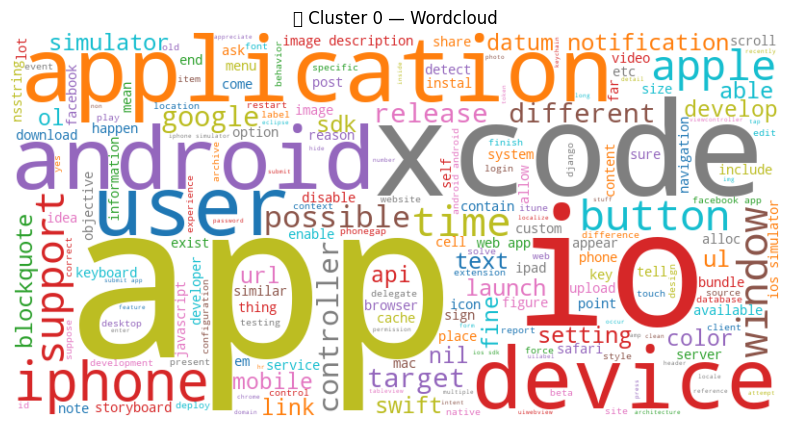

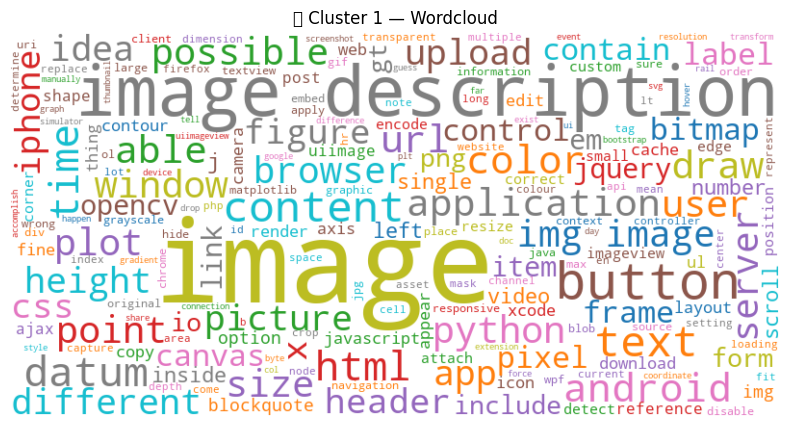

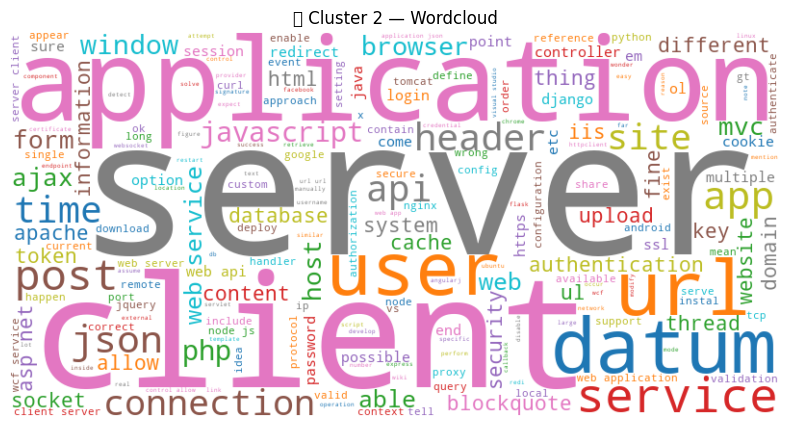

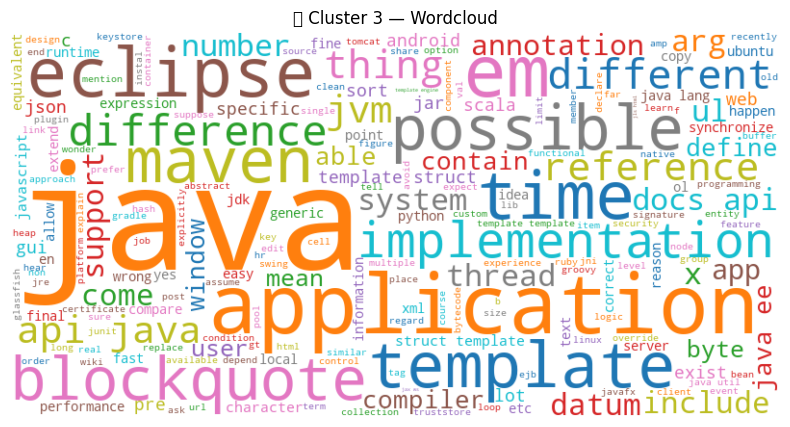

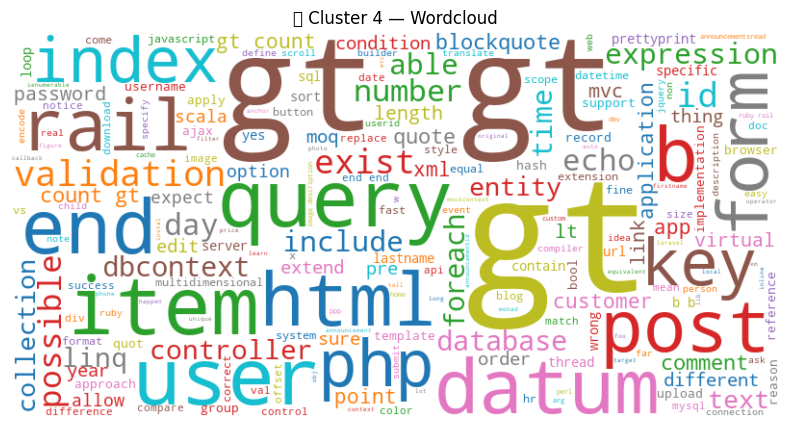

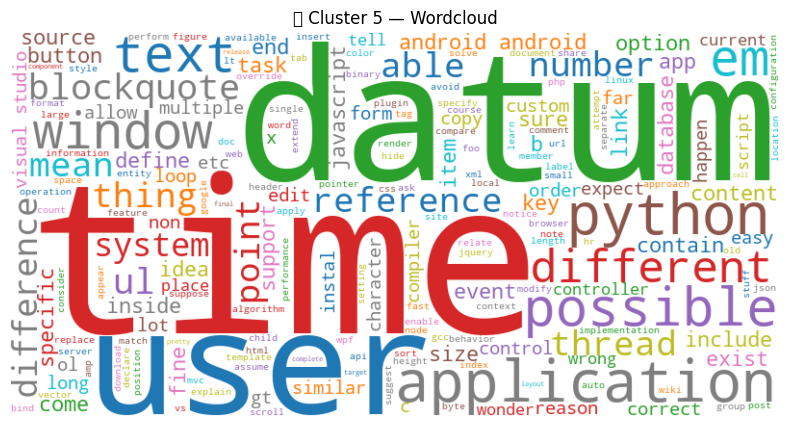

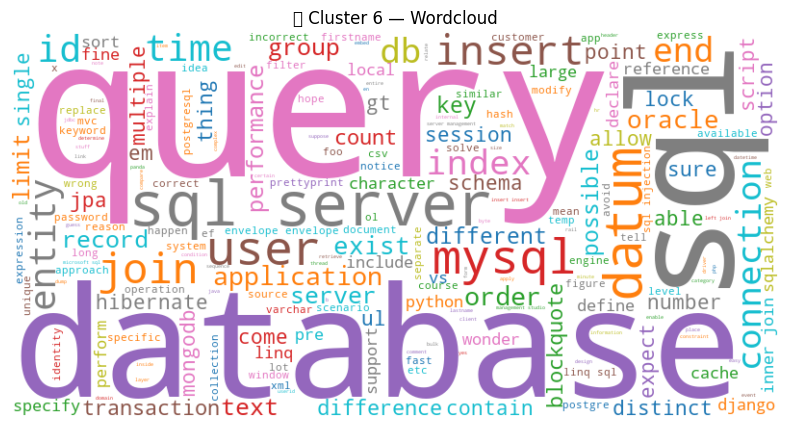

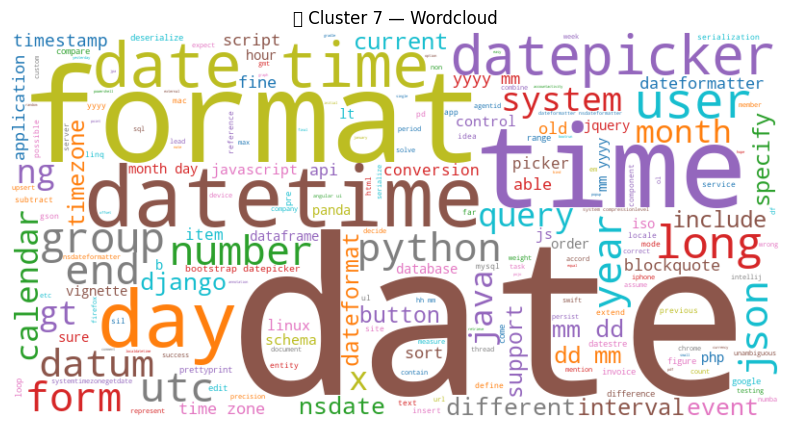

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for c in sorted(df_clusters_kmeans["cluster"].unique()):
    cluster_text = " ".join(df_clusters_kmeans[df_clusters_kmeans["cluster"] == c]["document"])
    wc = WordCloud(width=800, height=400, background_color="white", colormap="tab10").generate(cluster_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"🌐 Cluster {c} — Wordcloud")
    plt.show()


d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


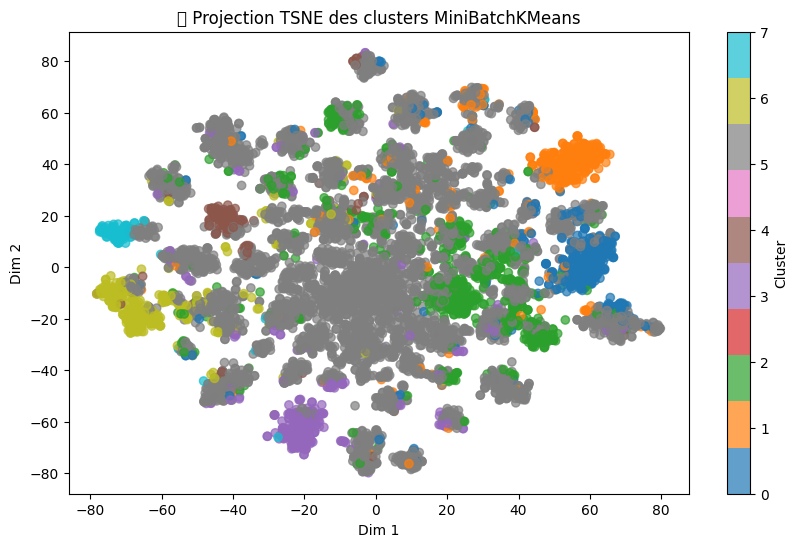

In [20]:
from sklearn.manifold import TSNE

X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_reduced)
plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title("📍 Projection TSNE des clusters MiniBatchKMeans")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label="Cluster")
plt.show()


## ANNEXES

### A1. MISE A L'ECHELLE (`modèle non supervisé LDA`)

Ce notebook a été développé sur `sample_df` pour tester la logique d’extraction thématique via LDA.

***Objectif à l’échelle : identifier les thématiques latentes dans 50 000 questions, à partir de vecteurs BoW.***

| Étape | Action | Détails |
|-------|--------|---------|
|  Chargement du corpus textuel | Import du corpus nettoyé (`clean_title_body`) | Fichier `corpus_for_lda.csv` |
|  Vectorisation BoW | Application du `CountVectorizer` | Paramètres : `max_df=0.95`, `min_df=5`, stopwords anglais |
|  Matrice BoW | Résultat : `X_bow` (shape : n_docs × n_vocab) | Stockée dans `corpus_for_lda_bow.pkl` |
|  Extraction du vocabulaire | `get_feature_names_out()` | Stockée dans `corpus_for_lda_vocab.pkl` |
|  Modélisation LDA | Application du modèle LDA via `sklearn` ou `gensim` | `n_topics` à tester selon cohérence visuelle |
|  Visualisation des topics | Utilisation de `pyLDAvis`, `TSNE`, WordClouds | Permet d’interpréter les regroupements |
|  Évaluation qualitative | Lecture des documents top-par-topic | Aide à la cartographie thématique du corpus |

 Cette modélisation peut servir de base à la suggestion de tags ou à la navigation intelligente dans le corpus.
